# Fitting Parameters for SARS Data

## Overview

This is a study COVID data. The analysis provides plots of fits and parameter estimates. 

### Data (CoV_nasal.csv)

- 9 patients (columns)

### State variables

- $T$: number of target cells
- $E$: number of exposed cells (virus replicating inside, not yet spreading virus)
- $I$: number of infected cells (active virus production)
- $V$: viral titre, in units of TCID50/ml of biofluid wash (for Influenza)

### Model: $T \rightarrow E \rightarrow I \rightarrow \emptyset$
 $\frac{dT}{dt} = - \beta T V$
 
 $\frac{dE}{dt} =  \beta T V - \kappa E$
 
 $\frac{dI}{dt} = \kappa E - \delta I$
 
 $\frac{dV}{dt} = p y(I) - c y(V)$

In [2]:
# Python packages used
import os
import numpy as np
import pandas as pd
import SBstoat
from SBstoat.modelStudy import ModelStudy
%matplotlib inline

In [5]:
# Programming Constants Used in Analysis. Constants are in all capital letters.
USE_SERIALIZED = False  # Use saved values of fitting from a previous bootstrap (if present)
DO_SERIALIZE = False  # Update the saved values of fitted data
DIR = "/home/ubuntu/SBstoat/examples/virus"  # Directory where the data are
FILE_NAME = "SARS_CoV2_nasal.csv"  # Name of the file containing the observed data
NUM_BOOTSTRAP_ITERATION = 1000  # Number of bootstrap iterations, if bootstrapping is done
VIRUS = "log10V"  # Name of the state variable that corresponds to the observed data

## Study for Baseline Model

In [3]:
ANTIMONY_MODEL  = '''
    // Equations
    E1: T -> E ; beta*T*V ; // Target cells to exposed
    E2: E -> I ; kappa*E ;  // Exposed cells to infected
    E3: -> V ; p*I ;        // Virus production by infected cells
    E4: V -> ; c*V ;        // Virus clearance
    E5: I -> ; delta*I      // Death of infected cells    

    // Parameters - from the Influenza article,
        
    beta = 3.2e-5;  // rate of transition of target(T) to exposed(E) cells, in units of 1/[V] * 1/day
    kappa = 4.0;    // rate of transition from exposed(E) to infected(I) cells, in units of 1/day
    delta = 5.2;    // rate of death of infected cells(I), in units of 1/day
    p = 4.6e-2;     // rate virus(V) producion by infected cells(I), in units of [V]/day
    c = 5.2;        // rate of virus clearance, in units of 1/day

    // Initial conditions
    T = 4E+8 // estimate of the total number of susceptible epithelial cells
             // in upper respiratory tract)
    E = 0
    I = 0
    V = 0.75 // the dose of virus in TCID50 in Influenza experiment; could be V=0 and I = 20 instead for a natural infection
    
    // Computed values
    log10V := log10(V)

'''

### 1. Data Setup`

The rows are patients; the columns are times. We need to create separate data for each patient.

In [6]:
# Transform the input data into separate data sources.
path = os.path.join(DIR, FILE_NAME)
patients = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9"]
dataSourceDct = SBstoat.modelStudy.mkDataSourceDct(path, VIRUS,
                                                   dataSourceNames=patients, isTimeColumns=True)

In [7]:
# dataSourceDct is a python dictionary. The key is 'Pn', where n is the patient number.
# The value is a time series for that patient.
dataSourceDct

{'P1':             log10V
 time              
 0.0            NaN
 1.0            NaN
 2.0            NaN
 3.0   7.880300e+00
 4.0   3.990000e+00
 5.0   2.496500e-15
 6.0   1.246900e+00
 7.0   3.142100e+00
 8.0   1.845400e+00
 9.0   2.693300e+00
 10.0  1.122200e+00
 11.0  2.020000e+00
 12.0  2.496500e-15
 13.0  3.167100e+00
 14.0 -2.493800e-02
 15.0 -2.493800e-02
 16.0  2.496500e-15
 17.0  2.493800e-02
 18.0 -2.493800e-02
 19.0  2.496500e-15
 20.0  2.496500e-15
 21.0  2.496500e-15
 22.0           NaN
 23.0           NaN
 24.0           NaN
 25.0           NaN
 26.0           NaN
 27.0           NaN,
 'P2':         log10V
 time          
 0.0        NaN
 1.0        NaN
 2.0   7.634800
 3.0   6.098200
 4.0   4.924800
 5.0   4.533400
 6.0   4.170000
 7.0   1.376500
 8.0   2.661100
 9.0   1.878700
 10.0  0.006915
 11.0  0.000000
 12.0  1.151500
 13.0  1.207000
 14.0  0.000000
 15.0  0.000000
 16.0  0.005059
 17.0  0.004758
 18.0  0.004442
 19.0  0.000000
 20.0       NaN
 21.0       NaN
 22

### 2. Transform the simulation results to units of observed values
The observed values are in units of log10. So, simulation results must
be converted to these units. This is done by using an assignment rule in the simulation model.
For this model, the assignmnt rule is ``log10V := log10(V)``.

### 3. Specify permissible values for parameters
For each parameter, provide a tuple of its: lower bound, upper bound, and starting value.

In [8]:
# Parameter value ranges: lower, upper, initial value
parameterDct = dict(
      beta=(0, 10e-5, 3.2e-5),
      kappa=(0, 10, 4.0),
      delta=(0, 10, 5.2),
      p=(0, 1, 4.6e-2),
      c=(0, 10, 5.2)
      )

### 4. Run the model and produce plots.

In [11]:
# Run a study
def runStudy(model, dirStudyPath):
    #logger = SBstoat._logger.Logger(logLevel=SBstoat._logger.LEVEL_STATUS)
    logger = _logger.Logger()
    study = ModelStudy(model,                     # Antimony model to evaluate
                   dataSourceDct,                 # Data sources to use for fitting
                   parameterDct=parameterDct,     # Parameters and their value ranges
                   dirStudyPath=dirStudyPath,     # Where to store the results of bootstrapping
                   selectedColumns=["log10V"],    # Output column is computed in the assignment rule
                   doSerialize=DO_SERIALIZE,      # Save the results of bootstrapping
                   logger=logger,                 # Use defined logging options
                   useSerialized=USE_SERIALIZED)  # Use previously calculated bootstrap results if they are present

    study.bootstrap(numIteration=NUM_BOOTSTRAP_ITERATION)  # Do bootstrapping
    print("\n\n")
    study.plotFitAll()                                     # Plot fitted and observed values with band plots for confidence
    print("\n\n")
    study.plotParameterEstimates()                         # Plot the parameter estimates for each data source





0.002409: ***Doing bootstrapp for instance P1***



0.213804: ***Running bootstrap for 1000 successful iterations with 5 processes.***

30.043700:     (Bootstrap completed 1000 total iterations with 745 successes.)

41.032148:     (Process 1: completed bootstrap.)

41.276274:     (Process 3: completed bootstrap.)

41.513594:     (Process 5: completed bootstrap.)

42.130580:     (Process 4: completed bootstrap.)

43.946015:     (Process 2: completed bootstrap.)


44.012622: 
 **1000 bootstrap estimates of parameters.



44.013068: ***Doing bootstrapp for instance P2***



44.161172: ***Running bootstrap for 1000 successful iterations with 5 processes.***

71.071290:     (Process 3: completed bootstrap.)

71.216929:     (Bootstrap completed 1000 total iterations with 980 successes.)

71.664484:     (Process 1: completed bootstrap.)

71.934585:     (Process 4: completed bootstrap.)

71.955144:     (Process 2: completed bootstrap.)

72.547271:     (Process 5: completed bootstrap.)


72.

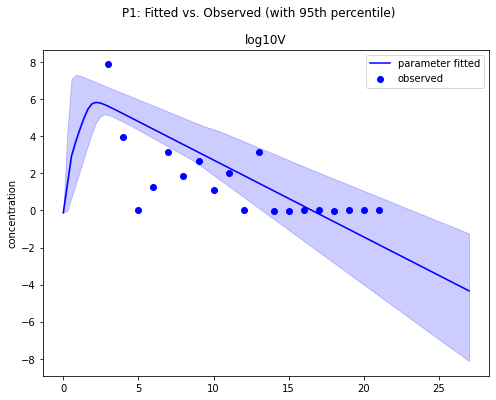

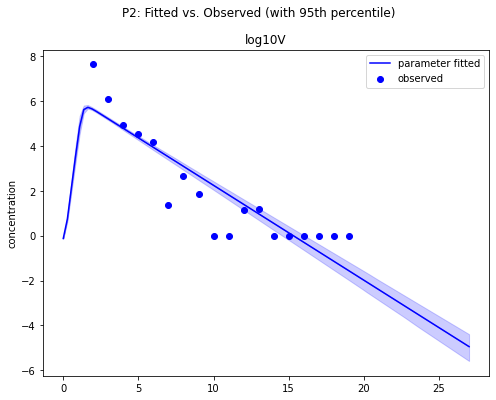

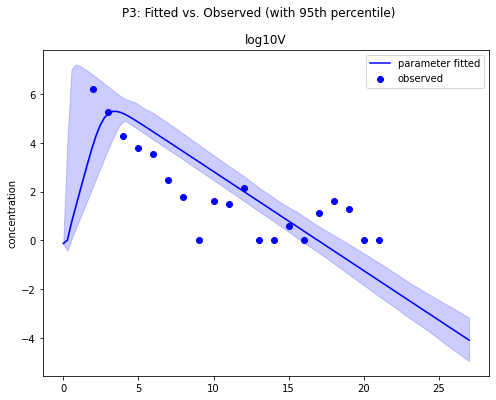

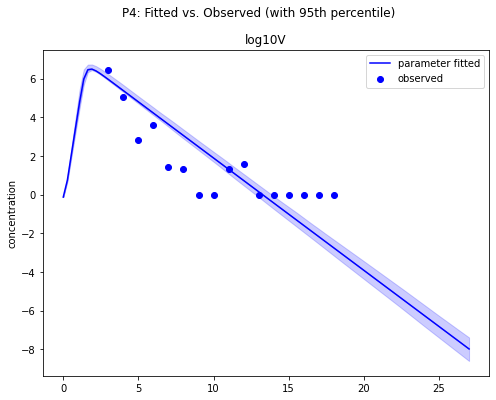

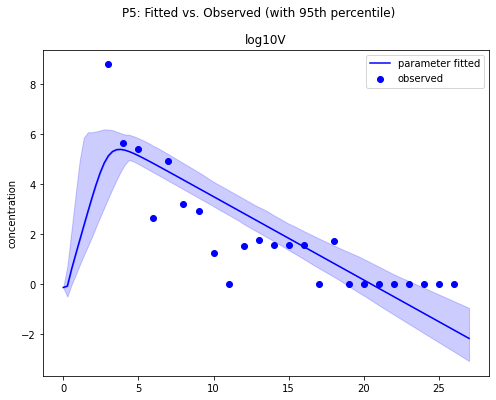

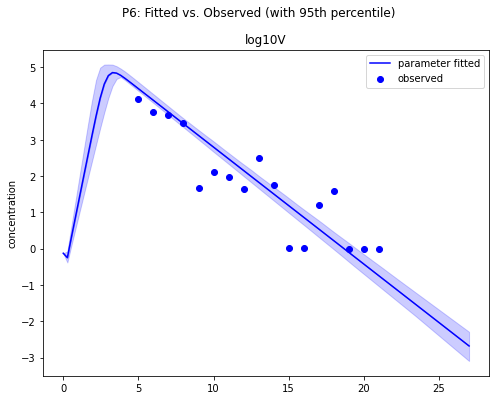

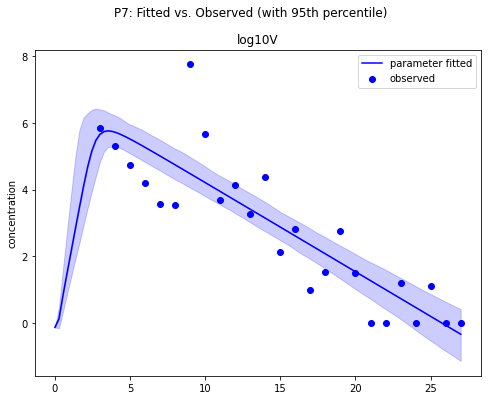

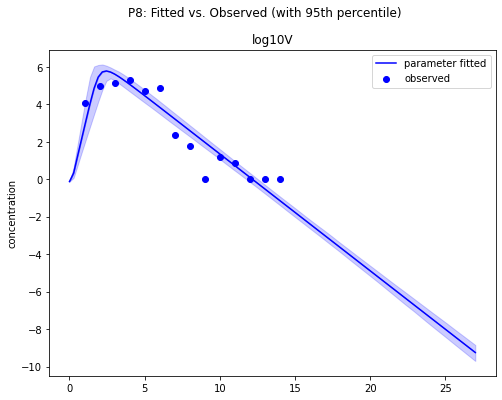

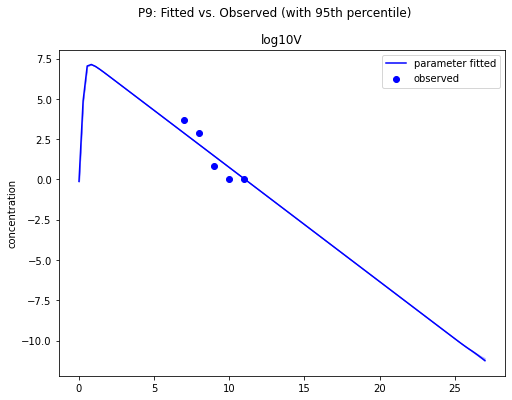

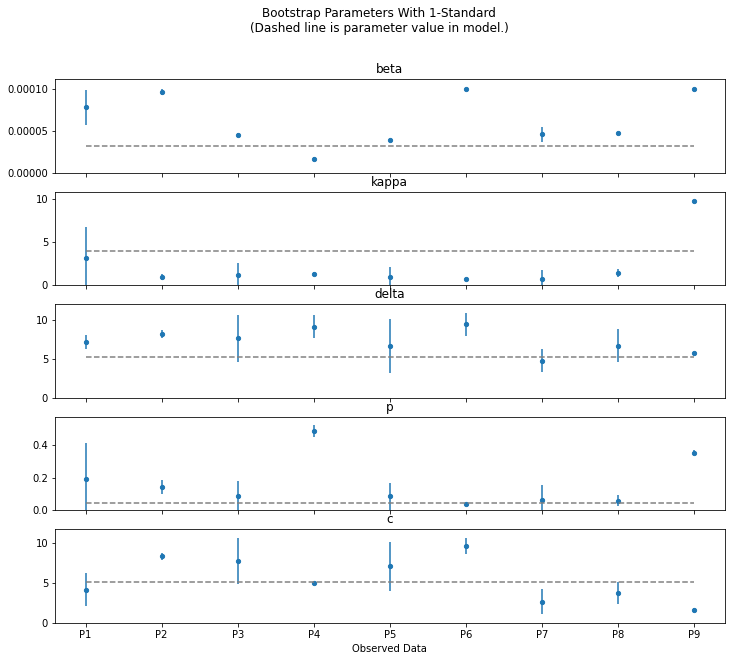

In [10]:
dirStudyPath = os.path.join(DIR, "ModelStudyFitters_01")
runStudy(ANTIMONY_MODEL, dirStudyPath)